<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Parallel_Sync_CNN_Research_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel Synchronous Gradient Descent CNN Research
In this notebook, I am led by graduate student Pengzhan Guo to create a synchronous CNN that can be parallelized between multiple supercomputers and is optimized by the best gradient descent networks (ADAM or RMSProp).

A sample run of the CNN will be completed with the CIFAR10 dataset and that framework will be applied here as well. The network will be based on the <a href="https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py" target="_blank">VGG16 design</a> that was proposed by K. Simonyan and A. Zisserman. 

How else could you create a custom CNN?

In [1]:
!pip3 install keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=98b2b037a52481948c37e3ddc1e76e4c2d12fe4ea96899150637fcbc1d31e01a
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=4855e2cb2789383e4f6546691887c58164502c49c9e424984cc7fe2293d04d8e
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from PIL.Image import ANTIALIAS


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.python.client import device_lib
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
from kerastuner import Objective

import random
import tarfile
import zipfile
import os
import concurrent.futures

from os.path import exists
from warnings import simplefilter

Since Keras has not updated alongside Pandas to note this warning noting users to do this,
```
df[index] --> df.iloc[index]
```
there will be a bunch of warnings while training the CNN. Let's remove it.



In [3]:
simplefilter(action='ignore', category=FutureWarning)

# Setting Up Google Drive
This will be used later to save the model before the runtime disconnects.

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Retrieving the Datasets

First, I am getting the version of `TF Keras`, TF 2.0 makes the creation of neural networks a lot easier. 

The devices variable will make finding all CPUs and GPUs in the computer easier.

In [5]:
# DEBUG
print(tf.keras.__version__)
devices = device_lib.list_local_devices()

2.4.0


## [Camelyon17 Dataset](https://camelyon17.grand-challenge.org/Data/)

Title of Dataset: **PatchCamelyon** 

The following is a direct quotation from the *TensorFlow Datasets* [documentation](https://www.tensorflow.org/datasets/catalog/patch_camelyon) for the dataset.


> "The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than Imagenet, trainable on a single GPU."

Since my full deep learning benchmark with *CIFAR10* used only `numpy` arrays, we are going to load the entire dataset into one batch for consistancy via `tfds.load(batch_size=-1)`.

Unfortunately, the dataset is so large it does not fit into memory. Using 20% of the examples (exactly 52,429 of the 327,680 examples) is enough to place the dataset into memory and load it as a `numpy` array. Then, we can append our additional examples to add more types of data for the classifier!

Also note that the dataset is set to be in a 50/50 balance. Good job dataset creator!





In [ ]:
import tensorflow_datasets as tfds

# Load the data as a single batch
(ds_train, ds_info) = tfds.load('patch_camelyon', split='train[:13%]', shuffle_files=True, with_info=True, batch_size=-1, as_supervised=True)
ds_test = tfds.load('patch_camelyon', split='test[:13%]', shuffle_files=True, batch_size=-1, as_supervised=True)
ds_train

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

The following is basic information about the dataset via its additional `DatasetInfo` object.

In [ ]:
ds_info

If you load the dataset via its `as_supervised` parameter set to **True** and have it as an entire batch via `batch_size=-1`, then you can easily access the dataset as a tuple of `numpy` arrays.

The **first** item of the tuple is the array of training images and the **second** item of the tuple are the labels of the images.

In [ ]:
import matplotlib.pyplot as plt

train_data = tfds.as_numpy(ds_train)
test_data = tfds.as_numpy(ds_test)

x_train_ds, y_train_ds = train_data
x_test_ds, y_test_ds = test_data

plt.imshow(x_train_ds[0])

No need for shuffling since the data is already shuffled when it is loaded from the **TFDS** dataset.

## [Cancer Imaging Archive Dataset](https://wiki.cancerimagingarchive.net/display/Public/Breast+Metastases+to+Axillary+Lymph+Nodes)

Title of Dataset: **Breast Metastases to Axillary Lymph Nodes**

There are 130 SVS images of the effect of breast cancer on lymph nodes. The data is imbalanced with more instances showing benign carcinoma rather than metastatic carcinoma. The labels are already encoded with 0 indicating benign carcinoma and 1 indicating malignant carcinoma.

**The strategy:**
1. To identify breast cancer cells, you need to convert them from the slide data to standard jpeg images. It would also be a good idea to resize them to a reasonable size (96 x 96 for continuity with the appended dataset [see above] )
2. In order to do this, you can read the zip file and align items with a `pd.DataFrame` so that the proper training and testing items are shuffled and split.
3. Then, we can convert the PILLOW images from the directories and start some numerical preprocessing with the intensity arrays from the *PatchCamelyon* Dataset.

Side Note: How do I save the images without using too much storage? (Many gigabytes and megabytes x 140)

In [ ]:
output_folders = []

for folder in os.listdir("."):
    full_path: str = os.path.join(os.getcwd(), folder)  
    if folder.endswith(".zip"):
        with zipfile.ZipFile(full_path) as zf:
            name = full_path.replace(".zip", "")
            zf.extractall(name)
    elif folder.endswith(".tar.gz"):
        with tarfile.open(full_path) as tf:
            name = full_path.replace(".tar.gz", "")
            print(name)
            output_folders.append(name)
            tf.extractall(name)

/content/Output6
/content/Output5
/content/Output2
/content/Output1
/content/Output3
/content/Output4
/content/Output7


In [ ]:
import shutil

# Total Number of Files: 150 (Sample)

outputs_path = os.path.join(os.getcwd(), "outputs")

if not os.path.exists(outputs_path):
  # shutil.rmtree(outputs_path)
  os.mkdir(outputs_path)

pic_directory = []

for subfolder in output_folders:
  for pic_dir in os.listdir(subfolder):
      pic_directory.append(os.path.join(subfolder, pic_dir))

# print(pic_directory)
# for output in pic_directory:
#   print(len(os.listdir(output)))
print(pic_directory)

for output in pic_directory:
  for file in os.listdir(output):
    print(os.path.join(outputs_path, file))
    shutil.move(os.path.join(output, file), os.path.join(outputs_path, file))


['/content/Output6/Output', '/content/Output5/Output', '/content/Output2/Output', '/content/Output1/Output', '/content/Output3/Output', '/content/Output4/Output', '/content/Output7/Output']
/content/outputs/HobI17-085745661307.png
/content/outputs/HobI17-036398431404.png
/content/outputs/HobI16-850322983160.png
/content/outputs/HobI16-837889994938.png
/content/outputs/HobI17-117814883069.png
/content/outputs/HobI17-054246972264.png
/content/outputs/HobI17-092737210733.png
/content/outputs/HobI17-054128333834.png
/content/outputs/HobI17-192632085422.png
/content/outputs/HobI17-074732741064.png
/content/outputs/HobI17-188975055458.png
/content/outputs/HobI17-176780238278.png
/content/outputs/HobI17-219470745199.png
/content/outputs/HobI17-213453116848.png
/content/outputs/HobI16-800515347962.png
/content/outputs/HobI17-158487016760.png
/content/outputs/HobI16-708082515907.png
/content/outputs/HobI17-247547626174.png
/content/outputs/HobI17-203923657811.png
/content/outputs/HobI17-0146688

### Parallelzing the I/O for Reading Images!

So now we are going to read the images and get each of their filenames. The images have already been transformed to JPEG images in the zip files so we just need to read them as `PIL` images and resize them to keep a common shape between all images in both directories.

In [ ]:
# choose the best size
size = (96, 96)

def read_images(directory: str) -> np.ndarray:
  # print(directory)
  print([os.path.join(directory, img) for img in os.listdir(directory) 
  if img.endswith(".png") or img.endswith(".jpg")])

  imgs = [load_img(os.path.join(directory, img)) for img in sorted(os.listdir(directory)) 
  if img.endswith(".png") or img.endswith(".jpg")]
  # print(imgs)
  thumbnails = [img.resize(size, ANTIALIAS) for img in imgs]

  # FOR THUMBNAILS (LARGE IMAGES)
  # [img.thumbnail(size, ANTIALIAS) for img in imgs]
  # thumbnails = [img for img in imgs]
  # print(thumbnails)

  # PUT SOMEWHERE ELSE --> arrays = [img_to_array(img) for img in thumbnails]
  return thumbnails

Parallelizing I/O, here we go!

['/content/outputs/HobI18-593216593303.png', '/content/outputs/HobI16-673050001795.png', '/content/outputs/HobI18-494717903184.png', '/content/outputs/HobI18-246204354838.png', '/content/outputs/HobI18-789815111269.png', '/content/outputs/HobI17-085745661307.png', '/content/outputs/HobI17-324909994030.png', '/content/outputs/HobI17-036398431404.png', '/content/outputs/HobI16-105105202254.png', '/content/outputs/HobI16-850322983160.png', '/content/outputs/HobI17-440719796933.png', '/content/outputs/HobI18-386778904831.png', '/content/outputs/HobI18-069937884593.png', '/content/outputs/HobI18-173605056616.png', '/content/outputs/HobI17-974235225863.png', '/content/outputs/HobI17-558005179666.png', '/content/outputs/HobI17-800973460562.png', '/content/outputs/HobI17-659203035810.png', '/content/outputs/HobI18-116874549628.png', '/content/outputs/HobI18-045092912528.png', '/content/outputs/HobI17-255403409805.png', '/content/outputs/HobI18-331819024579.png', '/content/outputs/HobI18-559324

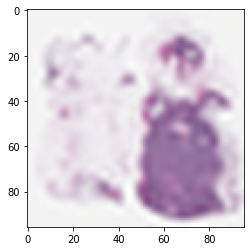

In [ ]:
# read in fixed order
bc_images = read_images(outputs_path)
plt.imshow(bc_images[0])

### Aligning the dataframe with the resized pictures

This first part is an assertion to find out the number of images in the folder so that it matches with the target `DataFrame`.

In [ ]:
print(len(os.listdir(outputs_path)))

130


*Now*, we can sort the images and filenames (in order) by zipping them and then add it to the dataframe

In [ ]:
import pandas as pd

df = pd.read_csv('target.csv')

df['slide'] = df['slide'].str.replace(".svs", ".jpg")
df = df.sort_values('slide') # just in case

df

,slide,target
0,HobI16-053768896760.jpg,1
1,HobI16-072823783181.jpg,1
2,HobI16-105105202254.jpg,0
3,HobI16-303757967057.jpg,0
4,HobI16-334188031493.jpg,0
...,...,...
125,HobI18-711038761484.jpg,0
126,HobI18-767451561893.jpg,0
127,HobI18-789815111269.jpg,1
128,HobI18-796881418672.jpg,0


Since I do not employ parallelism and I read the images in order, I do not need to sort the images for the dataframe. Thus, `df[slide]` are the names of the images and `bc_images` are the images (PILLOW).

In [ ]:
combined = list(zip(bc_images, df['slide'].values))
print(combined)

sorted_images = [img_pair[0] for img_pair in combined]

df['imgs'] = sorted_images

[(<PIL.Image.Image image mode=RGB size=96x96 at 0x7F62331793C8>, 'HobI16-053768896760.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F6233179438>, 'HobI16-072823783181.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F62331794A8>, 'HobI16-105105202254.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F6233179518>, 'HobI16-303757967057.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F6233179588>, 'HobI16-334188031493.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F62331795F8>, 'HobI16-553454144783.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F6237EDDA58>, 'HobI16-568713100973.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F6237F48BE0>, 'HobI16-673050001795.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F6233179668>, 'HobI16-708082515907.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F62331796D8>, 'HobI16-723628532151.jpg'), (<PIL.Image.Image image mode=RGB size=96x96 at 0x7F6233179748>, 'HobI16-7323174

Because this is in order, the dataframe now contains all of the images!!

In [ ]:
df.head()

,slide,target,imgs
0,HobI16-053768896760.jpg,1,<PIL.Image.Image image mode=RGB size=96x96 at ...
1,HobI16-072823783181.jpg,1,<PIL.Image.Image image mode=RGB size=96x96 at ...
2,HobI16-105105202254.jpg,0,<PIL.Image.Image image mode=RGB size=96x96 at ...
3,HobI16-303757967057.jpg,0,<PIL.Image.Image image mode=RGB size=96x96 at ...
4,HobI16-334188031493.jpg,0,<PIL.Image.Image image mode=RGB size=96x96 at ...


Tada, now we have all the images and labels sorted! 

We can now do any of the preprocessing we want with the sorted images!

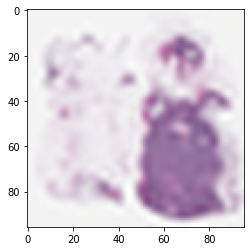

In [ ]:
# Assertion
plt.imshow(df['imgs'][0])

# Preprocessing the Data

In [ ]:
def normalize_train(train_vec: np.ndarray):
  """ Normalizes the data by dividing by subtracting the mean 
      and dividing by the standard deviation. Akin to scikit-learn's
      StandardScaler."""
  mean_train = np.mean(train_vec)
  std_train = np.std(train_vec)
  return (train_vec - mean_train) / std_train

Before we apply preprocessing to the data, we need to transform all of the PIL images into arrays of pixel intensities.

Now, we can shuffle and split the data using `train_test_split` from scikit-learn

In [ ]:
xi_train, xi_test, y_train, y_test = train_test_split(df['imgs'], 
                                                    df['target'], random_state=42, stratify=df['target'])

print(xi_train.shape)
print(y_train.shape)
print(xi_test.shape)
print(y_test.shape)

(97,)
(97,)
(33,)
(33,)


### Converting `PIL` image --> Intensity Array




In [ ]:
xl_train = []
for i in xi_train:
  xl_train.append(img_to_array(i))

xl_test = []
for i in xi_test:
  xl_test.append(img_to_array(i))

x_train, x_test = np.array(xl_train), np.array(xl_test)


print(f"X TRAIN: {x_train[0]} \n\n")
print(f"X TEST: {x_test[0]}")

print(f"X TRAIN SHAPE: {x_train.shape}")
print(f"X TEST SHAPE: {x_test.shape}")
print(f"Y TRAIN SHAPE: {y_train.shape}")
print(f"Y TEST SHAPE: {y_test.shape}")

X TRAIN: [[[242. 242. 243.]
  [242. 242. 243.]
  [242. 242. 243.]
  ...
  [241. 240. 241.]
  [241. 240. 241.]
  [241. 240. 241.]]

 [[242. 242. 243.]
  [242. 242. 243.]
  [242. 242. 243.]
  ...
  [241. 240. 241.]
  [241. 240. 241.]
  [241. 240. 241.]]

 [[242. 242. 243.]
  [242. 242. 243.]
  [242. 242. 243.]
  ...
  [241. 240. 241.]
  [241. 240. 241.]
  [241. 240. 241.]]

 ...

 [[242. 242. 242.]
  [242. 242. 242.]
  [242. 242. 242.]
  ...
  [238. 238. 239.]
  [237. 237. 238.]
  [237. 237. 238.]]

 [[242. 242. 242.]
  [242. 242. 242.]
  [242. 242. 242.]
  ...
  [237. 237. 239.]
  [237. 237. 238.]
  [237. 237. 238.]]

 [[242. 242. 242.]
  [242. 242. 242.]
  [242. 242. 242.]
  ...
  [237. 237. 239.]
  [237. 237. 238.]
  [237. 237. 238.]]] 


X TEST: [[[243. 243. 243.]
  [243. 243. 243.]
  [243. 242. 243.]
  ...
  [241. 241. 242.]
  [241. 241. 242.]
  [241. 241. 242.]]

 [[243. 243. 243.]
  [243. 243. 243.]
  [243. 242. 243.]
  ...
  [241. 241. 242.]
  [241. 241. 242.]
  [241. 241. 242.]]

### Visualization of Class Imbalance

#### Class Weights!

In [ ]:
is_camelyon = False

if is_camelyon:
  total_labels = np.append(y_train_ds, y_test_ds)
else:
  total_labels = df['target']

Both datasets have different class balances. We cannot add them as it messes up the balance. The *Cancer Imaging Database* dataset has more imbalance than the 50/50 *PatchCamelyon* data.

In [ ]:
benign = len(total_labels[total_labels == 0]) # benign is 0
malignant = len(total_labels[total_labels == 1]) # malignant is 1
total = benign + malignant

print(f"Benign Samples: {benign} ({round(benign / total, 3) * 100}% of total)")
print(f"Malignant Samples: {malignant} ({round(malignant / total, 3) * 100}% of total)")
print(f"Total Samples: {total}")

weight_benign = (1 / benign) * (total) / 2.0
weight_malignant = (1 / malignant) * (total) / 2.0

class_weights = {0: weight_benign, 1: weight_malignant}

print()
print(f"Weight for class 0 [benign]: {round(weight_benign, 3)}")
print(f"Weight for class 1 [malignant]: {round(weight_malignant, 3)}")

Benign Samples: 94 (72.3% of total)
Malignant Samples: 36 (27.700000000000003% of total)
Total Samples: 130

Weight for class 0 [benign]: 0.691
Weight for class 1 [malignant]: 1.806


#### Visualization

Could show this in two ways. The first will be through a standard **histogram** and then I will configure a **pie chart** for a prettier view!

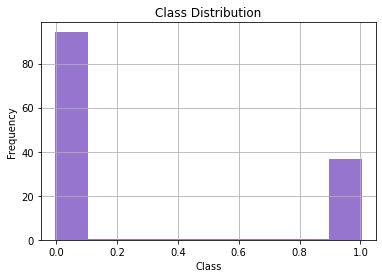

In [ ]:
# Histogram
plt.hist(total_labels, histtype='step', fill=True, color='#9575cd', linewidth=3)
plt.title("Class Distribution")
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(True)

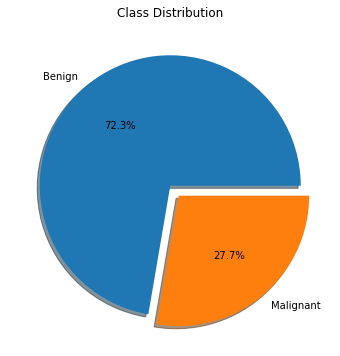

In [ ]:
explode = (0, 0.1)

plt.pie([benign, malignant], labels=['Benign', 'Malignant'], 
        shadow=True, explode=explode, autopct='%1.1f%%')
plt.title("Class Distribution")

fig = plt.gcf()
fig.set_size_inches(6, 6)

## Visualizing the Data

I am going to look at a couple of the data points before normalization

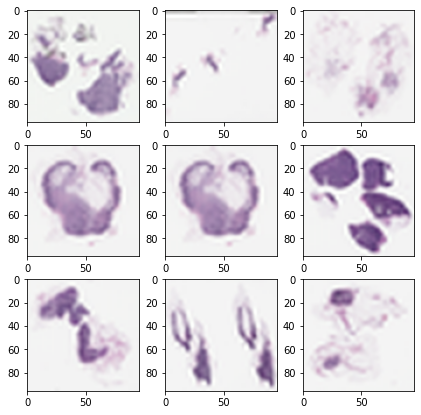

In [ ]:
from random import choice

def visualize_cifar(train_data):
  """ Visualizes the cifar-10 dataset using matplotlib. This helps give a greater understanding
      of the items that are in the dataset"""
  plt.figure(figsize=(7, 7))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(choice(train_data) / 255)

# if CIFAR
visualize_cifar(x_train)

## Back to Preprocessing

And now, we prepare the data for preprocessing!

*   As of the last code cell, the training vectors **X** are already converted to `ndarrays` and normalized by dividing by the mean and standard deviation (StandardScaler a la `scikit-learn`.
* Now, we just need to add a data generator to increase the amount of train data we have



In [ ]:
x_train, x_test = normalize_train(x_train), normalize_train(x_test)

print(f"X TRAIN: {x_train[0]} \n\n")
print(f"Y TRAIN: {x_test[0]}")


X TRAIN: [[[0.49160746 0.49160746 0.5189769 ]
  [0.49160746 0.49160746 0.5189769 ]
  [0.49160746 0.49160746 0.5189769 ]
  ...
  [0.46423805 0.4368686  0.46423805]
  [0.46423805 0.4368686  0.46423805]
  [0.46423805 0.4368686  0.46423805]]

 [[0.49160746 0.49160746 0.5189769 ]
  [0.49160746 0.49160746 0.5189769 ]
  [0.49160746 0.49160746 0.5189769 ]
  ...
  [0.46423805 0.4368686  0.46423805]
  [0.46423805 0.4368686  0.46423805]
  [0.46423805 0.4368686  0.46423805]]

 [[0.49160746 0.49160746 0.5189769 ]
  [0.49160746 0.49160746 0.5189769 ]
  [0.49160746 0.49160746 0.5189769 ]
  ...
  [0.46423805 0.4368686  0.46423805]
  [0.46423805 0.4368686  0.46423805]
  [0.46423805 0.4368686  0.46423805]]

 ...

 [[0.49160746 0.49160746 0.49160746]
  [0.49160746 0.49160746 0.49160746]
  [0.49160746 0.49160746 0.49160746]
  ...
  [0.38212973 0.38212973 0.40949917]
  [0.3547603  0.3547603  0.38212973]
  [0.3547603  0.3547603  0.38212973]]

 [[0.49160746 0.49160746 0.49160746]
  [0.49160746 0.49160746 0.4

In [ ]:
NUM_CLASSES = 1

print(x_train.shape)
# x_train = x_train.astype("float32")
# x_test = x_test.astype("float32")

# Preprocessing the image dataset by artificially increasing the training data size
# via rescaling, shifting, flipping and rotating the dataset.
data_gen = ImageDataGenerator(
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

data_gen.fit(x_train)

(97, 96, 96, 3)


# Building The Model
The models were built by using a combination of methods from the Inceptionv3 model and the VGGNet models that are on Github. The layers used are given in the imports in the first code cell.

In [ ]:
import tensorflow as tf

def cancer_tunable(hp, output_bias=None):
    model = tf.keras.models.Sequential()

    reg_factor = hp.Choice('regularization', [1e-5, 1e-6, 1e-7])
    default_filter = 64

    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    
    # Layer 1
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter1', min_value=16, 
                                            max_value=256, step=16), (3, 3), 
                                      kernel_initializer=tf.keras.initializers.he_normal(), 
                                    input_shape=(96, 96, 3),
    padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-2', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", 
                                      kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling2D(2, 2))

      # Layer 2
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-3', min_value=16, 
                                            max_value=256, step=16), (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-4', min_value=16, 
                                            max_value=256, step=16), 1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-4b', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_val-1', min_value=0.2, max_value=0.45, step=0.05)))

    # Layer 3
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-5', min_value=16, 
                                            max_value=256, step=16), (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-6', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 4
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-7', min_value=16, 
                                            max_value=256, step=16), (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-8', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling2D(2, 2))


    # Layer 5
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-9', min_value=16, 
                                            max_value=256, step=16), (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-10', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.MaxPooling2D(1, 1))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_val-2', min_value=0.2, max_value=0.49, step=0.05)))


    # END OF CONVOLUTIONS - HERE LIES DENSE FLATTENING!

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Int('dense-1', min_value=16, max_value=90, step=8) * 64, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(hp.Int('dense-2', min_value=16, max_value=90, step=8) * 64, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(NUM_CLASSES, bias_initializer=output_bias))
    model.add(tf.keras.layers.Activation('sigmoid'))

    optimizer = tf.keras.optimizers.SGD(lr=hp.Choice('lr', [1e-5, 1e-3, 5e-4]), momentum=0.9, nesterov=True)


  # COMPILING THE MODEL!
    model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC()])

    return model

In addition to the model above, we need to initialize a smaller model to work for smaller datasets.

The Python file containing the model function will be saved in **Google Drive**. All we need to do is copy the file from drive and import the `cancer_net` method to override the previous declaration.

This may be commented out when necessary.

#### Importing Smaller Models


In [14]:
!cp '/content/drive/My Drive/Colab Notebooks/res/cancernet1.py' .
!cp '/content/drive/My Drive/Colab Notebooks/res/cancernet2.py' .
!cp '/content/drive/My Drive/Colab Notebooks/res/cancernet3.py' .

print('Start of Cancer Net 1 Program', '\n')
!head '/content/drive/My Drive/Colab Notebooks/res/cancernet1.py'
print('\n', 'Start of Cancer 2 Program', '\n')
!head '/content/drive/My Drive/Colab Notebooks/res/cancernet2.py'

Start of Cancer Net 1 Program 

'''
Cancer Net Model building function with 1 Layers

'''

import tensorflow as tf
from kerastuner import HyperParameters

def cancer_tunable(hp, output_bias=None):
    model = tf.keras.models.Sequential()

 Start of Cancer 2 Program 

'''
Cancer Net Model building function with 2 Layers

'''

import tensorflow as tf
from kerastuner import HyperParameters

def cancer_tunable(hp, output_bias=None):
    model = tf.keras.models.Sequential()


In [ ]:
# Initialize the hyperparameters for the hyperparameters in each file.

trainable_3 = ('regularization', 'filter1', 'filter-2', 'filter-3', 'filter-4', 'filter-4b', 'filter-5', 
             'filter-6', 'filter-7', 'filter-8', 'filter-9', 'filter-10',
             'dropout_val','dropout_val-1', 'dropout_val-2', 'dropout_val-3', 'lr', 'dense-1', 'dense-2')

trainable_2 = ('regularization', 'filter1', 'filter-2', 'filter-3', 'filter-4', 'filter-4b', 'filter-5', 
             'filter-6', 'filter-7', 'filter-8', 'filter-9', 'filter-10',
             'dropout_val','dropout_val-1', 'dropout_val-2', 'dropout_val-3', 'lr', 'dense-1', 'dense-2')

trainable_1 = ('regularization', 'filter1', 'filter-2', 'filter-3', 'filter-4', 'filter-4b', 'filter-5', 
             'filter-6', 'filter-7', 'filter-8', 'filter-9', 'filter-10',
             'dropout_val','dropout_val-1', 'dropout_val-2', 'dropout_val-3', 'lr', 'dense-1', 'dense-2')

## Getting The Best Hyperparameters

In this block, we are going to create a hyperparameter tuner with the help of **keras-tuner** to find the best hyperparameters for this problem. The second code block is how you can tune how often the tuner runs.

**Why is there an output bias with a natural log factor? See [this](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias) link for more info.**

Essentially setting the bias correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias. (Paraphrased from [Andrej Karpathy Blog](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines) )


---




The correct bias has the formula$\ b_0 = \log(\frac{p}{n})$ where$\ b_0$ is the last output layer's bias,$\ p$ is the quantity of the smaller class and$\ n$ is the quantity of the larger class.

The default bias without output bias initialization is$\ \log(2) \approx 0.69314$.

In [ ]:
output_bias = np.log([malignant / benign])
print(output_bias)

[-0.95977584]


Now, I am going to set up the auto-tuned hyperparameters for the model.

In [ ]:
hp = HyperParameters()
model = cancer_tunable(hp, output_bias)

tf.keras.utils.plot_model(model, 'cancer-vis.png', show_shapes=True)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
batch_normalization_26 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 96, 96, 16)        784       
_________________________________________________________________
batch_normalization_27 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 48, 16)       

In [ ]:
tuner = RandomSearch(
    cancer_tunable,
    objective=Objective("auc", "max"),
    max_trials=5,
    executions_per_trial=3,
    directory='test_dir'
)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project test_dir/untitled_project/oracle.json


In [ ]:
# CID - Cancer Imaging Database

callbacks = []
sample_path = os.path.join(os.getcwd(), "kerastuner-cid.hdf5")

callbacks.append(tf.keras.callbacks.EarlyStopping('val_auc', verbose=1, 
                                                  patience=50, 
                                                  restore_best_weights=
                                                  True))
callbacks.append(tf.keras.callbacks.ModelCheckpoint(sample_path, 
                                                    monitor='val_auc', 
                                                    save_weights_only=False,
                                                    save_best_only=True, 
                                                    verbose=1, 
                                                    save_freq='epoch'))

Above: Basic callbacks to monitor the progress. Not really needed.

Below: The actual parameter tuning. It will take around 5 hours to tune the model for around 750 epochs. A **large batch size** is required because of the class imbalance so all classes are captured in the mini-batch.

However, if the `UnboundLocalError` occurs, then lower the batch size!!!

In [ ]:
EPOCHS = 50
BATCH_SIZE = 2 # for small data only

tuner.search(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      epochs=EPOCHS,
                      steps_per_epoch=(len(x_train) // BATCH_SIZE),
                      class_weight=class_weights, 
                      validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 7.5580 - accuracy: 0.2842 - auc: 0.5000
Epoch 00001: val_auc improved from inf to 0.50000, saving model to /content/kerastuner-cid.hdf5
48/48 [==============================] - 55s 1s/step - loss: 7.5580 - accuracy: 0.2842 - auc: 0.5000 - val_loss: 11.1006 - val_accuracy: 0.2727 - val_auc: 0.5000
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 7.6690 - accuracy: 0.2737 - auc: 0.5000
Epoch 00002: val_auc did not improve from 0.50000
48/48 [==============================] - 54s 1s/step - loss: 7.6690 - accuracy: 0.2737 - auc: 0.5000 - val_loss: 11.1006 - val_accuracy: 0.2727 - val_auc: 0.5000
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 7.5580 - accuracy: 0.2842 - auc: 0.5000
Epoch 00003: val_auc did not improve from 0.50000
48/48 [==============================] - 55s 1s/step - loss: 7.5580 - accuracy: 0.2842 - auc: 0.5000 - val_loss: 11.1006 - val_accuracy: 0.2727 - val_auc: 0

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]

If no hyperparameters saved, load it from the pickle file.

In [ ]:
import pickle

parameter_file = "/content/cancer-hyperparameters.p"

if os.path.exists(parameter_file):
  with open(parameter_file, 'rb') as pk:
    best_hps = pickle.load(pk)

Hyperparameters obtained from the model:

Saved via the *pickle* module.

In [ ]:
trainable = ('regularization', 'filter1', 'filter-2', 'filter-3', 'filter-4', 'filter-4b', 'filter-5', 
             'filter-6', 'filter-7', 'filter-8', 'filter-9', 'filter-10',
             'dropout_val','dropout_val-1', 'dropout_val-2', 'dropout_val-3', 'lr', 'dense-1', 'dense-2')

for search_space in trainable:
  print(f"The best value for the '{search_space}' variable was {best_hps.get(search_space)}")

In [ ]:
import pickle

with open(parameter_file, 'wb') as pk:
  pickle.dump(best_hps, pk)

Now, we print the models to see their summary and number of parameters in each.

In [ ]:
model_path = 'drive/My Drive/Colab Notebooks/best-cancer-model.hdf5'

tf.keras.utils.plot_model(model, 'cancer-vis.png', show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 16)        400       
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 16)         

# Executing the Model
Now, the model built above will be executed with the training set. If there are more than one GPUs on the computer this file is being called in, then it will parallelize the model between the GPUs, else it will execute on the one GPU and CPU. 

In [ ]:
print(tf.keras.__version__)

devices = device_lib.list_local_devices()
gpus = [devices[i].device_type in devices for (i, device) in enumerate(devices) if "GPU" in devices[i].device_type]

isParallel = any(gpus)
print(f"Are there any GPUs I can use? " {isParallel})


2.3.0-tf
[False, False]
25000


Setting up to tune the learning rate.

In [ ]:
%load_ext tensorboard
import tensorflow.keras.backend as K
from datetime import datetime
from tensorflow.keras.models import load_model

In [ ]:
kcallbacks = []
logdir = "logs/scalars/" + datetime.now().strftime("%m%d%y-%H%M%S")
model_path = 'drive/My Drive/Colab Notebooks/bestcancer-tunedmodel.hdf5'
kcallbacks.append(tf.keras.callbacks.ModelCheckpoint(model_path, 
                                                    monitor='val_auc', 
                                                    save_weights_only=False,
                                                    save_best_only=True, 
                                                    verbose=1, 
                                                    save_freq='epoch'))
kcallbacks.append(tf.keras.callbacks.TensorBoard(
    log_dir=logdir))

print(model_path, "\n", logdir)

In [ ]:
if os.path.exists(model_path):
  model = load_model(model_path)
  print(f'[INFO] Current Learning Rate of Model Is: {K.get_value(model.optimizer.lr)}')
  print(f'[INFO] Changing LR to {K.get_value(model.optimizer.lr) / 10}')
  K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) / 10)
  K.set_value(model.optimizer.lr, 5e-2)
  print(f'[INFO] New Learning Rate Is: {K.get_value(model.optimizer.lr)}')
else:
  model = tuner.hypermodel.build(best_hps)
  K.set_value(model.optimizer.lr, model.optimizer.lr * 10**2)
  print(f'[INFO] Current Learning Rate of Model Is: {K.get_value(model.optimizer.lr)}')

Adding the constants and showing the TensorBoard to track progress. I will add a confusion matrix later to adjust any preprocessing I need to improve the model.

In [ ]:
EPOCHS = 300
BATCH_SIZE = 200

history =
print(y_train.shape)


(50000, 1)


In [ ]:
%tensorboard --logdir logs/scalars

In [ ]:
print(model.optimizer.lr)

In [ ]:
if isParallel:
  print('GPUs parallelized!')
  model2 = tf.keras.utils.multi_gpu_model(model, 2)
  history = model2.fit(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test), class_weight=class_weights, 
                      callbacks=kcallbacks)
else:
  print('CPU Compilation')
  history = model.fit(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      epochs=EPOCHS,
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE),
                      class_weight=class_weights, 
                      validation_data=(x_test, y_test), callbacks=kcallbacks)
  model.save(model_path)

CPU Compilation


NameError: ignored

# Analyzing Results
Currently, the best results give a constant validation binary accuracy of .7564.

In [ ]:
main_results = model2.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
for metric, result in zip(model2.metrics_names, main_results):
  print(metric, " : ", result)

1250/1250 [==============================] - 4s 3ms/step - loss: 5.3644e-07 - AUC: 0.5000 - accuracy: 0.1000
loss  :  5.364418598219345e-07
AUC  :  0.5
accuracy  :  0.10000000149011612


In [ ]:
def plot_curve(train_data, test_data, figname, title, ylabel):
  plt.clf()
  plt.plot(train_data)
  plt.plot(test_data)
  plt.xlabel('Epoch')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig(figname)

In [ ]:
plot_curve(history.history['binary_acc'], 
           history.history['val_binary_acc'], 'model2acc.png', 
           'Model Accuracy vs Epoch', 
          'Accuracy')
plot_curve(history.history['loss'], 
           history.history['val_loss'], 'model2loss.png',
           'Model Loss vs Epoch', 'Loss')